### Punkt 1 i 2
Wybór białka (HNRNPC/HNRNPA2B1) analizowanego podczas eksperymentów, co
jednoznacznie identyfikuje wykorzystywany zestaw danych.

Zapoznanie się z motywem oczekiwanym, wyekstrahowanym na podstawie
eksperymentalnie określonej struktury 3D kompleksu, utworzonego przez analizowane
białko wiążące z RNA, w celu identyfikacji liczby wchodzących w jego skład nukleotydów
(len). Załóżmy, że nasz motyw oczekiwany to TTTT, wtedy len = 4.

In [1]:
import numpy as np
import pandas as pd
import stumpy

import math
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.decomposition import PCA
from src.datasets.dataset import Dataset

In [2]:
dataset = Dataset.read('./resources/datasets/HNRNPA2B1')

[memo::read-406c9d...] Loading from memory.


#### Pattern
plik tekstowy zawierający oczekiwany motyw
skojarzony z miejscem wiązania RNA-białko wyznaczony dla określonego kompleksu na
podstawie eksperymentalnie określonej struktury przestrzennej (uśredniona liczba
wiązań wodorowych dla nukleotydów rozpatrywanych w ramach miejsc wiązań z
białkami koreluje z ich wysoką reaktywnością wyznaczoną metodą fSHAPE). Plik zawiera
dane w postaci tabelarycznej (bez nagłówka) obejmując następujące kolumny
(oddzielone tabulatorami), a mianowicie wartość współczynnika fSHAPE oraz nazwę
zasady (A/C/T/G).

In [3]:
print(dataset.pattern.shape)
dataset.pattern

(11, 2)


,fshape_coefficient,base
0,0.0,NaN
1,1.0,NaN
2,2.0,A
3,3.0,G
4,2.0,G
5,0.0,NaN
6,0.0,NaN
7,1.0,T
8,0.5,A
9,0.5,G


#### Sites

archiwum obejmujące zestaw krótkich
fragmentów transkryptów służących do odkrywania powtarzalnych wzorców
stanowiących konsensus, które mogą stanowić nieznane dotąd, potencjalnie obiecujące
miejsca wiązań z rozpatrywanym białkiem. Każdy plik zawiera dane w postaci
tabelarycznej (bez nagłówka) obejmując następujące kolumny (oddzielone
tabulatorami), a mianowicie wartość współczynnika fSHAPE, nazwę zasady (A/C/T/G)
oraz opcjonalnie wartość współczynnika SHAPE.

In [18]:
print(len(dataset.sites))
dataset.sites[0].head()

71


,fshape_coefficient,base
0,4.222436,T
1,2.337724,T
2,4.173553,G
3,4.839571,A
4,4.003999,A


#### Search
archiwum obejmujące zestaw transkryptów,
które będą przeszukiwane z wykorzystaniem konserwatywnego(ych) motywu(ów)
odkrytego(ych) w poprzednim kroku w celu identyfikacji motywów charakteryzujących
się zbliżonym profilem danych fSHAPE (z-normalized Euclidean distance nie powinien
przekraczać wartości 2.5) oraz wysokim współczynnikiem podobieństwa sekwencyjnego. 

In [4]:
print(len(dataset.searches))
dataset.searches[0].head()

1098


,fshape_coefficient,base,shape_coefficient
0,NaN,G,NaN
1,NaN,C,NaN
2,0.410644,A,NaN
3,4.847446,C,NaN
4,0.286998,A,NaN


### Punkt 3
Określenie długości potencjalnie obiecujących motywów w = {len, len + 1, len + 2}.
Załóżmy, że nasz motyw oczekiwany to TTTT (len = 4), wtedy len + 1 = {NTTTT, TTTTN}, a
len + 2 = {NTTTTN}, gdzie N to dowolny nukleotyd.

In [6]:
expected_motif_length = len(dataset.pattern)
window_sizes = [expected_motif_length + x for x in range(3)]
window_sizes

[11, 12, 13]

### Punkt 4

Ekstrakcja wszystkich obiecujących, ciągłych motywów (reprezentowanych przez
odpowiadające im profile danych fSHAPE) o długości w = len … len + 2 spełniających
założoną charakterystykę miejsca wiązania, w oparciu o wartości współczynnika
reaktywności uzyskane metodą fSHAPE (tzn. wartość reaktywności dla przynajmniej
jednego nukleotydu w ramach motywu musi przekraczać wartość 1.0), spośród krótkich
fragmentów transkryptów zawartych w archiwum *identyfikator_wybranego_białka_binding_sites_fshape.zip*, które prawdopodobnie
zawierają nieodkryte dotąd miejsca wiązań RNA z rozpatrywanym białkiem.

In [19]:
def is_motif_promising(window: pd.Series) -> bool:
    return not window.isnull().any() and (window > 1).any()

In [8]:
promising_fshapes = defaultdict(list)
promising_motifs = defaultdict(list)

for site in dataset.sites:
    for window_size in window_sizes:
        for i in range(len(site) - window_size + 1):
            window = site.fshape_coefficient[i : i + window_size]

            if is_motif_promising(window):
                promising_fshapes[window_size].append(window.to_numpy())
                promising_motifs[window_size].append(site.base[i : i + window_size].to_numpy())

print(
    f"Example\nFshape: {promising_fshapes[window_sizes[0]][0]}\nMotif: {promising_motifs[window_sizes[0]][0]}"
)

Example
Fshape: [  4.2224361    2.33772398   4.17355287   4.83957116   4.00399883
   1.51389289   0.51807962 -10.56896471  -7.17275854 -11.53065754
  -3.00704761]
Motif: ['T' 'T' 'G' 'A' 'A' 'T' 'T' 'G' 'A' 'T' 'A']


In [9]:
for key, value in promising_fshapes.items():
    print(f"For window size {key} there are {len(value)} promising motifs")

For window size 11 there are 1573 promising motifs
For window size 12 there are 1624 promising motifs
For window size 13 there are 1669 promising motifs


### Punkt 5
Przeprowadzenie analizy skupień z wykorzystaniem przynajmniej dwóch metod (np.
KMEANS++, DBSCAN, itd.) dla zbioru motywów wyekstrahowanych w poprzednim kroku
dla każdej długości motywu (w) analizowanej niezależnie.

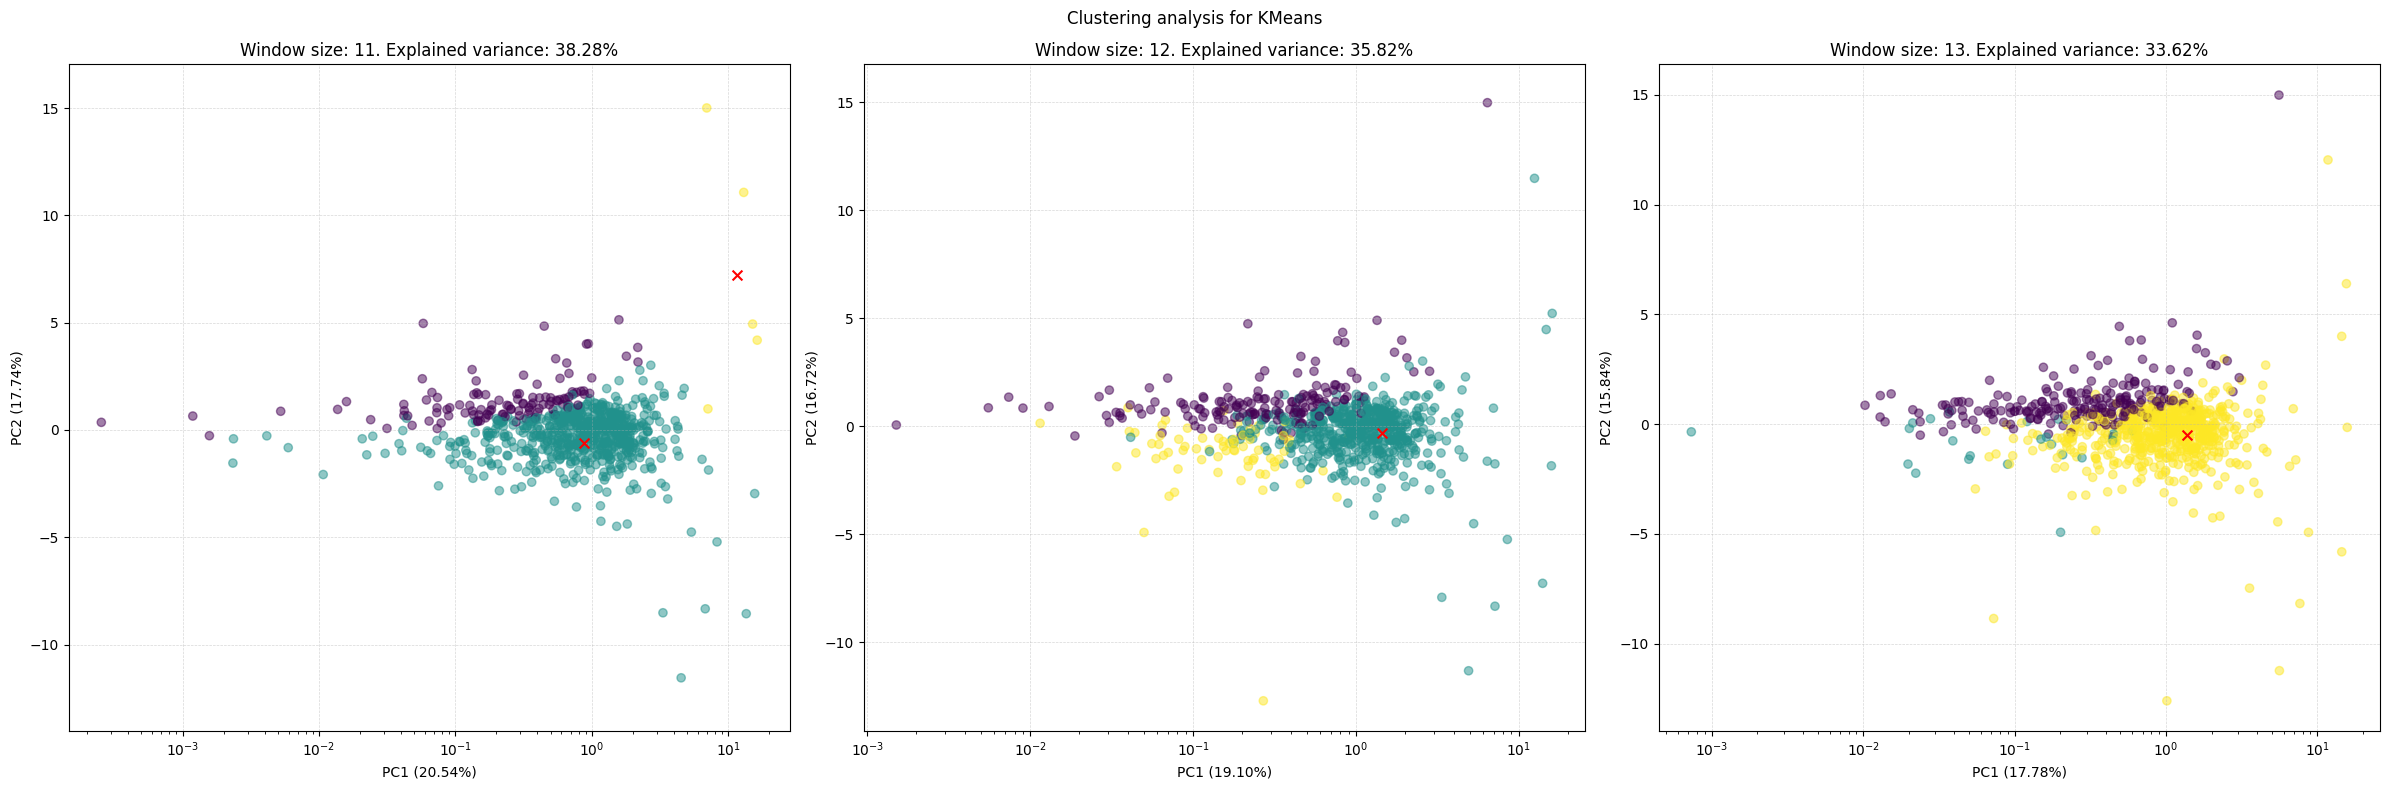

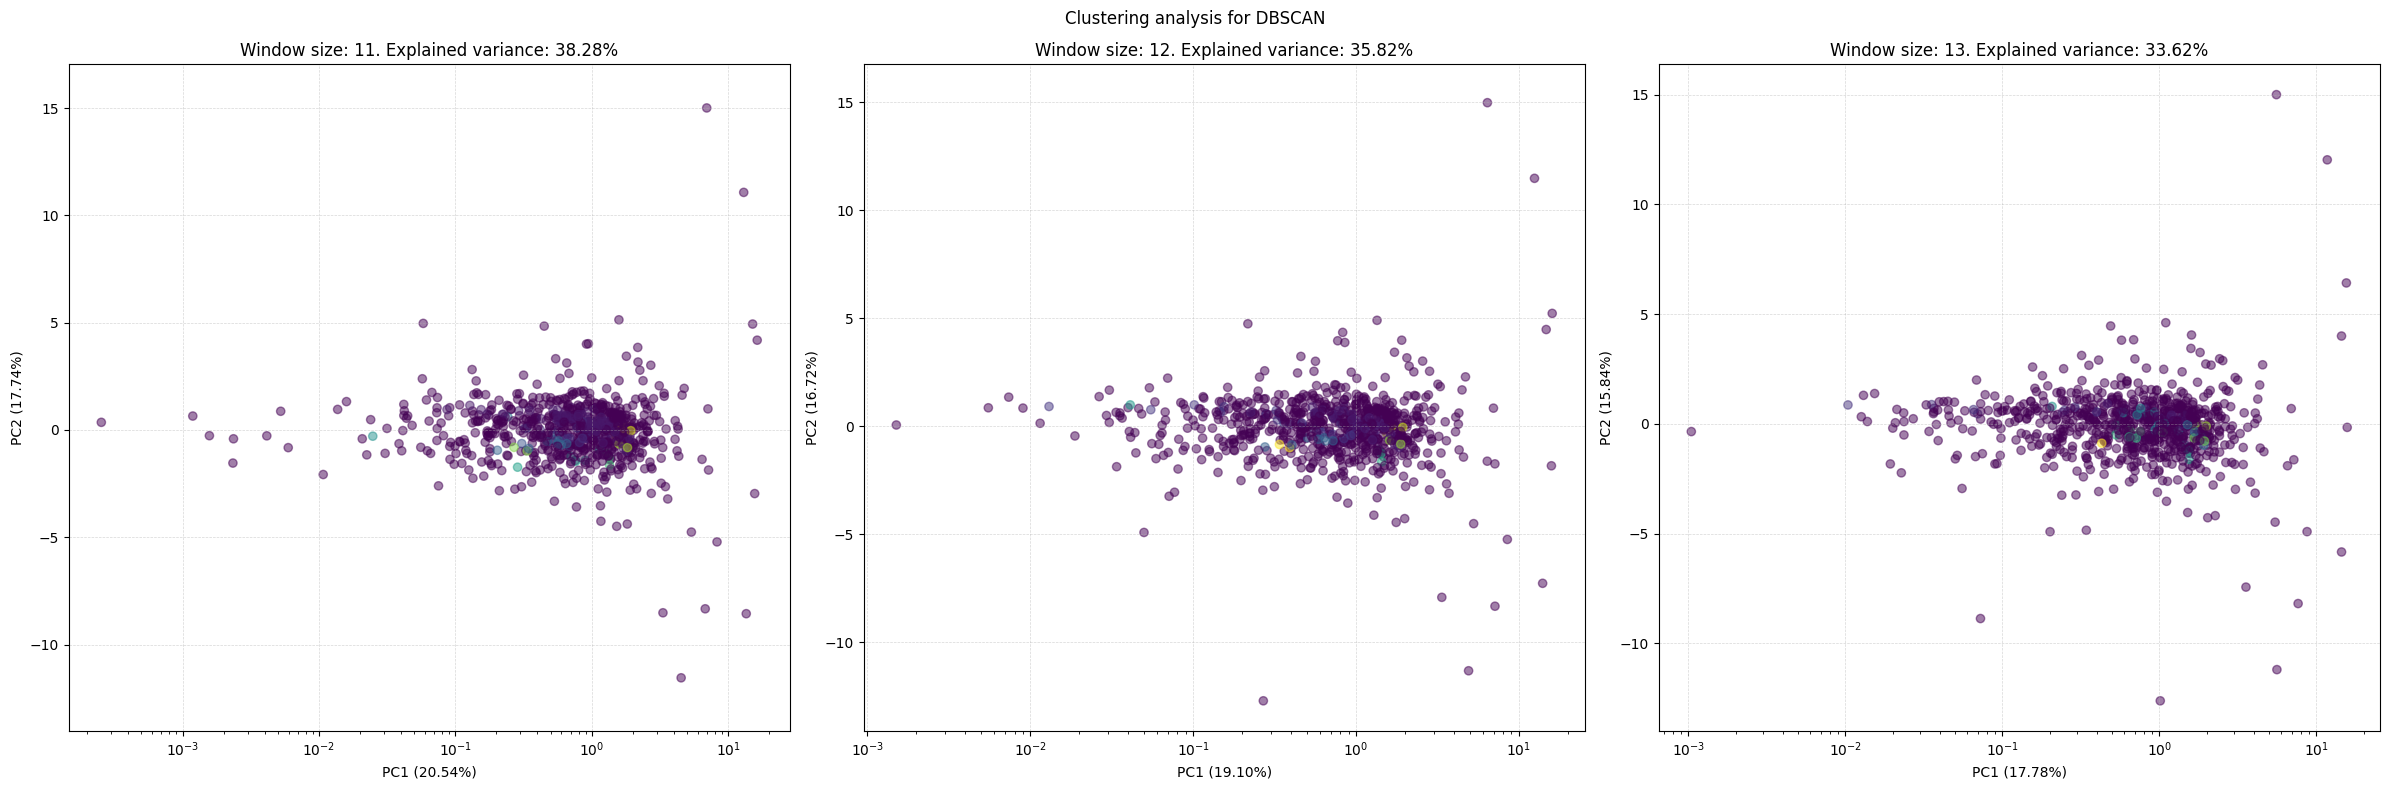

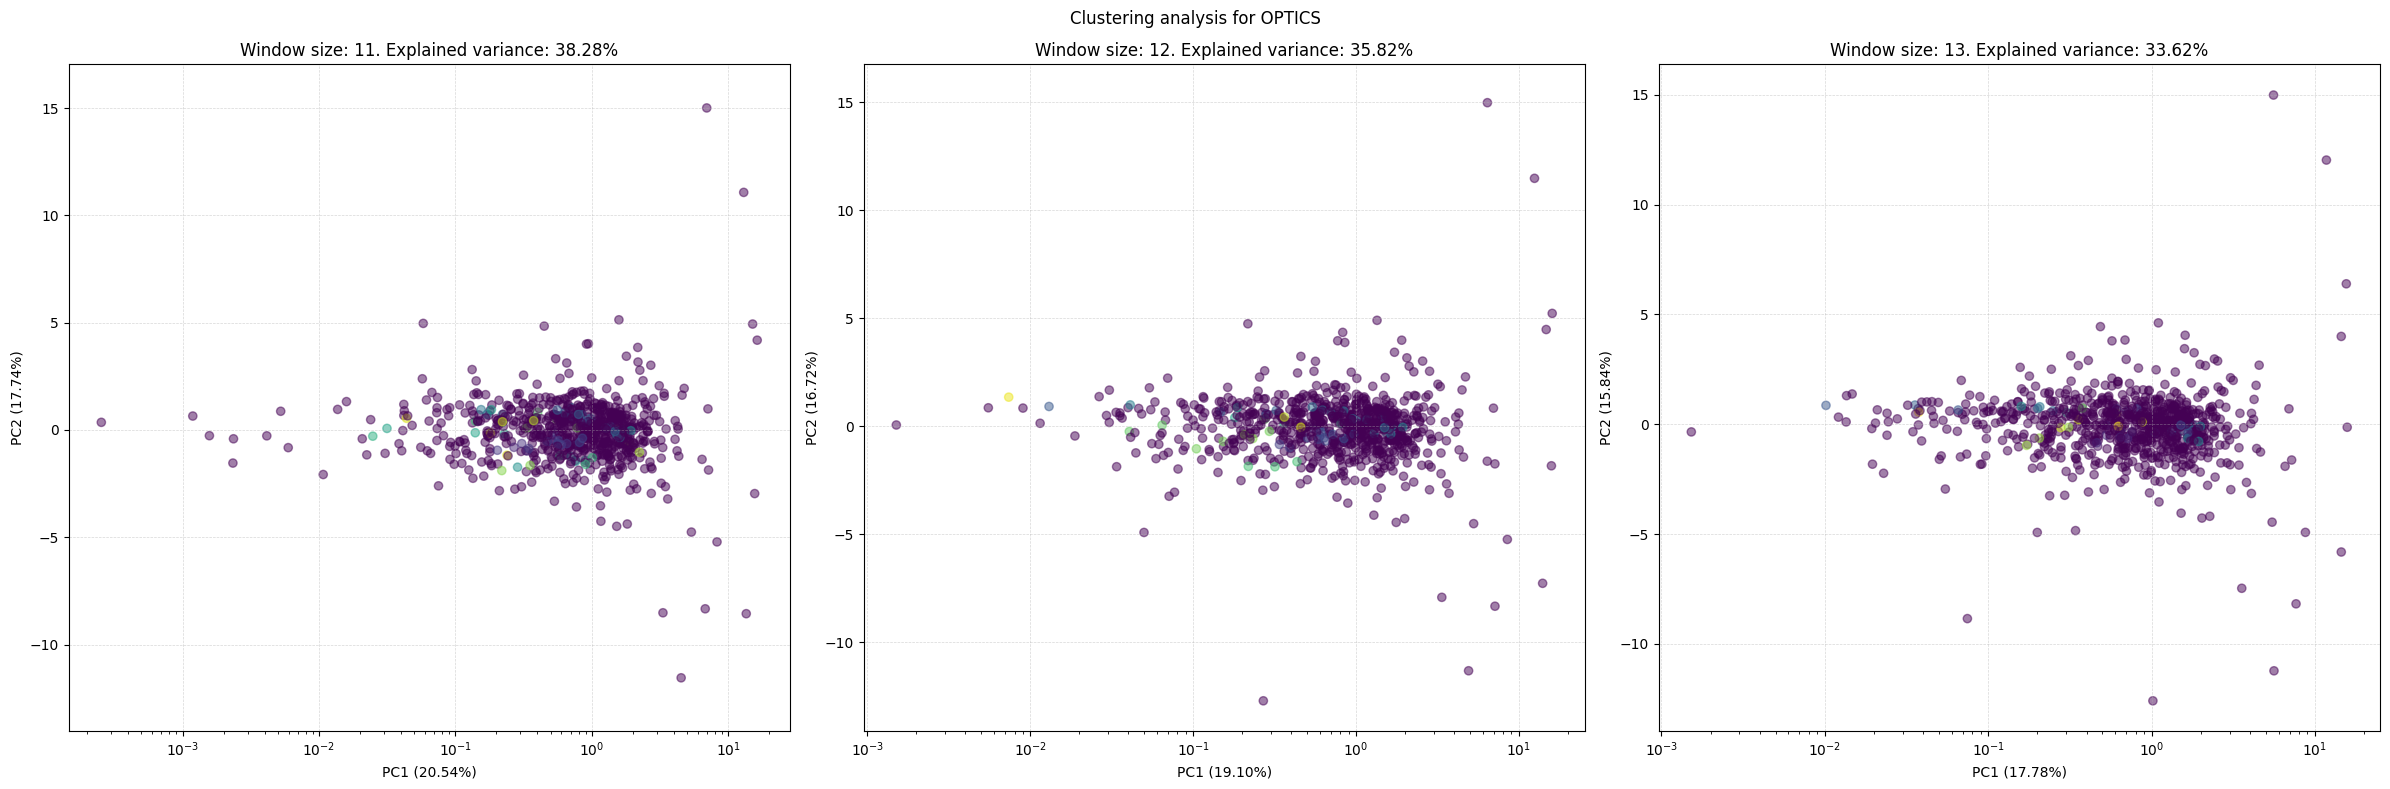

In [10]:
def perform_clustering_analysis(fshapes: defaultdict, model) -> None:
    fig, ax = plt.subplots(1, len(window_sizes), figsize=(24, 8), tight_layout=True)
    for i, window_size in enumerate(window_sizes):
        predicted = model.fit_predict(fshapes[window_size])
        pca = PCA(n_components=2)
        fshapes_reduced = pca.fit_transform(fshapes[window_size])

        ax[i].scatter(fshapes_reduced[:, 0], fshapes_reduced[:, 1], c=predicted, alpha=0.5)
        ax[i].set_title(
            f"Window size: {window_size}. Explained variance: {sum(pca.explained_variance_ratio_) * 100:.2f}%"
        )
        ax[i].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
        ax[i].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
        ax[i].grid(linestyle="--", linewidth=0.5, alpha=0.5)
        #  TODO: think if log scale is better for this case
        ax[i].set_xscale("log")

        if model.__class__.__name__ == "KMeans":
            cluster_centers = pca.transform(model.cluster_centers_)
            ax[i].scatter(
                cluster_centers[:, 0], cluster_centers[:, 1], marker="x", color="red", s=50
            )

    plt.suptitle(f"Clustering analysis for {model.__class__.__name__}")
    plt.show()


models = {
    "KMeans++": KMeans(n_clusters=3, init="k-means++", random_state=42),
    "DBSCAN": DBSCAN(eps=0.8, min_samples=3),
    "OPTICS": OPTICS(min_samples=3),
    # TODO: find better parameters (maybe elbow method for KMeans) and change 3rd model
}

for name, model in models.items():
    perform_clustering_analysis(promising_fshapes, model)

### Punkt 6, 7
Wyznaczenie obiecującego motywu konsensusowego (np. z wykorzystaniem biblioteki
STUMPY) na podstawie profili danych fSHAPE zawartych w trzech najbardziej licznych
klastrach zidentyfikowanych w poprzednim kroku (przy czym minimalna moc klastra, dla
którego należy wyznaczać motyw konsensusowy nie może być niższa niż 3).

Przeprowadzenie przeszukiwania transkryptów (np. z wykorzystaniem biblioteki
STUMPY), przechowywanych w archiwum identyfikator_wybranego_białka_ search
_fshape.zip, na podstawie profili danych fSHAPE wyekstrahowanych dla obiecujących
motywów konsensusowych zidentyfikowanych w poprzednim kroku oraz motywu
oczekiwanego. Opracowanie rezultatów w postaci tabelarycznej, gdzie każdy motyw
będzie opisany przez jego sekwencję, zakresy numerów nukleotydów, nazwę pliku
transkryptu, w którym został zidentyfikowany oraz wartości następujących miar, a
mianowicie znEd, ssf, aS wyznaczonych w kontekście motywu oczekiwanego. Rekordy
powinny być uporządkowane w porządku niemalejącym według ostatniej kolumny (aS).

In [11]:
def get_most_numerous_clusters(
    predicted: np.ndarray, window_size: int, n_clusters: int = 3) -> list:
    cluster_counts = Counter(predicted)
    cluster_counts.pop(-1, None)
    most_common_clusters = cluster_counts.most_common(n_clusters)
    print(f"Clusters for window size {window_size}: {most_common_clusters}")
    return [label for label, _ in most_common_clusters]


consensus_fshapes = [dataset.pattern.fshape_coefficient.to_numpy()]
consensus_motifs = [dataset.pattern.base.to_string(na_rep="N", index=False).replace("\n", "")]

for window_size in window_sizes:
    fshapes = np.array(promising_fshapes[window_size])
    motifs = np.array(promising_motifs[window_size])

    predicted = models["OPTICS"].fit_predict(fshapes)
    clusters = get_most_numerous_clusters(predicted, window_size)

    for cluster in clusters:
        cluster_fshapes = fshapes[predicted == cluster].tolist()
        cluster_motifs = motifs[predicted == cluster]

        _, idx, _ = stumpy.ostinato(cluster_fshapes, window_size)
        consensus_fshapes.append(cluster_fshapes[idx])
        consensus_motifs.append("".join(cluster_motifs[idx]))

        print(f"Consensus motif for cluster {cluster}: {''.join(cluster_motifs[idx])}")

Clusters for window size 11: [(1, 6), (0, 6), (25, 6)]
Consensus motif for cluster 1: GTGTTGCACCA
Consensus motif for cluster 0: GCCACTATGGC
Consensus motif for cluster 25: CCACTATGGCT
Clusters for window size 12: [(19, 7), (0, 6), (18, 6)]
Consensus motif for cluster 19: GCAAGTGACTTT
Consensus motif for cluster 0: GCCACTATGGCT
Consensus motif for cluster 18: CCACTATGGCTA
Clusters for window size 13: [(15, 6), (9, 5), (17, 5)]
Consensus motif for cluster 15: GCCACTATGGCTA
Consensus motif for cluster 9: ACTTGTTGGCGTA
Consensus motif for cluster 17: GCAAGTGACTTTC


In [12]:
def calculate_ssf(first_motif: str, second_motif: str) -> float:
    group_matches = ("AG", "CU", "CT")
    ssf_sum: int = 0
    for first, second in zip(first_motif, second_motif):
        if first == second or first == "N" or second == "N":
            ssf_sum += 2
            continue
        for group in group_matches:
            if first in group and second in group:
                ssf_sum += 1
                break
    return ssf_sum / len(first_motif)


math.isclose(round(calculate_ssf("NTTTTN", "TGATTT"), 2), 1.33)

True

In [13]:
def get_ssf(motif: str, window_size: int) -> float:
    base = dataset.pattern.base.to_string(na_rep="N", index=False).replace("\n", "")
    centered_base = base.center(window_size, "N")
    templates = set([centered_base, centered_base[::-1]])
    return max(calculate_ssf(motif, template) for template in templates)


def get_aS(znEd: float, ssf: float) -> float:
    return 10 * znEd - ssf


results: list = []

for search in dataset.searches:
    for consensus_fshape, consensus_motif in zip(consensus_fshapes, consensus_motifs):
        motif_length = len(consensus_motif)
        for i in range(len(search) - motif_length + 1):
            window = search.iloc[i : i + motif_length, :]
            znEd = stumpy.core.mass(consensus_fshape, window.fshape_coefficient)[0]

            if not is_motif_promising(window.fshape_coefficient) or znEd > 2.5:
                continue

            motif = window.base.to_string(na_rep="N", index=False).replace("\n", "")
            ssf = get_ssf(motif, window_size)
            aS = get_aS(znEd, ssf)

            results.append(
                {
                    "motif": consensus_motif,
                    "sequence": motif,
                    "start": i,
                    "end": i + motif_length,
                    "filename": "",
                    "znEd": znEd,
                    "ssf": ssf,
                    "aS": aS,
                }
            )
    break

In [14]:
results = pd.DataFrame(results)
results.sort_values("aS", inplace=True)
results

,motif,sequence,start,end,filename,znEd,ssf,aS
236,GCCACTATGGC,GAACACGAAGA,1430,1441,,0.655675,1.272727,5.284019
873,ACTTGTTGGCGTA,CCCTCTCCGCCTA,3411,3424,,0.675166,1.307692,5.443967
244,GCCACTATGGC,CAGGAAGACAT,1661,1672,,0.719352,1.454545,5.738977
373,CCACTATGGCT,AACACGAAGAG,1431,1442,,0.753833,1.636364,5.901971
545,GCCACTATGGCT,GAACACGAAGAG,1430,1442,,0.783789,1.333333,6.504557
...,...,...,...,...,...,...,...,...
330,GCCACTATGGC,GATTACTACGA,4463,4474,,2.490361,1.272727,23.630881
454,CCACTATGGCT,GATCTAACCAT,4314,4325,,2.493337,1.272727,23.660644
129,GTGTTGCACCA,GCTTGTGAAGC,1651,1662,,2.486091,1.181818,23.679093
55,NNAGGNNTAGN,AATTATCCCTG,2901,2912,,2.497502,1.272727,23.702294
